# to do
1. replace the root_dir and data_dir with path to training data if running on another CPU/GPU
2. change path to labels and images, and partition of train_files and var_files
3. build our own train_transformer and val_transformer, consider the effects of multimodal MRI
4. change cache dataset configurations and device name accordingly
5. which model should we use?
6. change AsDiscrete function for uncertainty maps

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

/home/yuexin/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite, einops]"

In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    RandAffined,
    GaussianSharpend,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np

print_config()

/home/yuexin/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


MONAI version: 1.4.dev2408
Numpy version: 1.24.3
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 39b752fefe096212bc7284786436c69d095c217e
MONAI __file__: /home/<username>/anaconda3/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.20.0
scipy version: 1.11.1
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.7.3
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.7.0
transformers version: 4.32.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs

In [4]:
# set up the root_dir and data_dir
directory = '/home/yuexin/Documents/MBP1413Data/'
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)
data_dir = '/home/yuexin/Documents/MBP1413Data/'
print(data_dir)

/home/yuexin/Documents/MBP1413Data/
/home/yuexin/Documents/MBP1413Data/


In [5]:
data_dicts = []
train_images = sorted(glob.glob(os.path.join(data_dir, "MICCAI_BraTS2020_TrainingData", "BraTS20_Training_*", "*[!g].nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "MICCAI_BraTS2020_TrainingData", "BraTS20_Training_*", "*_seg.nii.gz")))
for idx, image_name in enumerate(train_images):
    (q,r) = divmod(idx, 4)
    data_dicts.append({"image": train_images[idx], "label": train_labels[q]})
# data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
# divide dataset into 258 subjects for training, 55 subjects for validation, 55 subjects for testing
# train_files, val_files = data_dicts[0:1031], data_dicts[1032:1251]
train_files, val_files = data_dicts[0:10], data_dicts[11:20]

In [6]:
print(f"training data: {train_files}")
print(f"validating data: {val_files}")

training data: [{'image': '/home/yuexin/Documents/MBP1413Data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii.gz', 'label': '/home/yuexin/Documents/MBP1413Data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'}, {'image': '/home/yuexin/Documents/MBP1413Data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii.gz', 'label': '/home/yuexin/Documents/MBP1413Data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'}, {'image': '/home/yuexin/Documents/MBP1413Data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii.gz', 'label': '/home/yuexin/Documents/MBP1413Data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'}, {'image': '/home/yuexin/Documents/MBP1413Data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii.gz', 'label': '/home/yuexin/Documents/MBP1413Data/MICCAI_BraTS2020_Trai

In [7]:
set_determinism(seed=0)

In [16]:
# Define training transforms
# compose connect a series of transforms
train_transforms = Compose(
    [
        # Load image and label data
        LoadImaged(keys=["image", "label"]),
        # Ensure channel is the first dimension
        # pytorch work on tensor, batch x channel x height x width x depth
        EnsureChannelFirstd(keys=["image", "label"]),
        # Scale intensity values of the image within the specified range
        #ScaleIntensityRanged(
        #    keys=["image"],
        #    a_min=-57,
        #    a_max=164,
        #    b_min=0.0,
        #    b_max=1.0,
        #    clip=True,
        #),
        # Crop foreground from the image and label using the source image
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # Adjust the orientation of the image and label using RAS (Right, Anterior, Superior) axcodes
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Adjust the spacing of the image and label using specified pixel dimensions and interpolation modes
        # to make sure voxel size should be the same across all datasets
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        # Randomly crop regions with positive and negative labels to create training samples
         RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            # actual input size
            spatial_size=(64, 64, 64),
            # feature should be related to the foreground
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # Optionally, user can add other random transforms
        #RandAffined(
        #    keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(64, 64, 64),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)
        #     ),
        #GaussianSharpend(
        #    keys=["image", "label"],
        #    sigma1 = 3.0,
        #    sigma2 = 1.0,
        #    alpha = 30.0,
        #),
        # options: gaussian sharpening, random adjusting contrast
    ]
)

# Define validation transforms
val_transforms = Compose(
    [
        # Load image and label data
        LoadImaged(keys=["image", "label"]),
        # Ensure channel is the first dimension
        EnsureChannelFirstd(keys=["image", "label"]),
        # Scale intensity values of the image within the specified range
        #ScaleIntensityRanged(
        #    keys=["image"],
        #    a_min=-57,
        #    a_max=164,
        #    b_min=0.0,
        #    b_max=1.0,
        #    clip=True,
        #),
        # Crop foreground from the image and label using the source image
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # Adjust the orientation of the image and label using RAS (Right, Anterior, Superior) axcodes
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Adjust the spacing of the image and label using specified pixel dimensions and interpolation modes
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)


In [17]:
# Create a dataset using validation files and the specified validation transforms
check_ds = Dataset(data=val_files, transform=val_transforms)

# Create a DataLoader with a batch size of 1 for visualization purposes
check_loader = DataLoader(check_ds, batch_size=1)

# Retrieve the first batch of data from the DataLoader
check_data = first(check_loader)

# Extract the image and label from the data
image, label = (check_data["image"][0][0], check_data["label"][0][0])

# Print the shapes of the image and label
print(f"image shape: {image.shape}, label shape: {label.shape}")

image shape: torch.Size([86, 109, 68]), label shape: torch.Size([86, 109, 68])


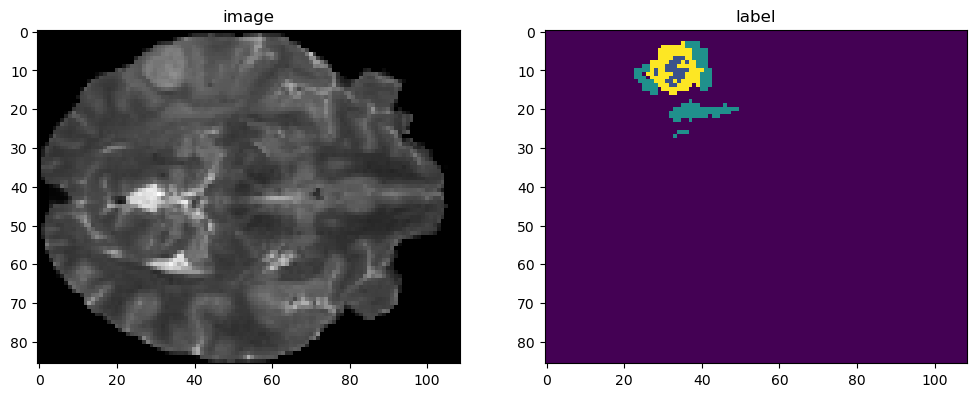

In [18]:
# Plot a slice of the images and labels (slice along the third dimension at index 30)
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 30])
plt.show()

In [19]:
# Takes about 4 minutes
# Create a CacheDataset for training with accelerated caching
# CacheRate is set to 1.0, caching the entire dataset for optimal performance
# NumWorkers enables multi-threading during caching for faster data loading
# apply data augmentation in the compose until probability(?) is hit
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)

# Alternatively, for experimentation with the regular Dataset, uncomment the line below:
# train_ds = Dataset(data=train_files, transform=train_transforms)

# Use DataLoader to load training data in batches of size 2
# Shuffle the data for randomization and apply RandCropByPosNegLabeld for data augmentation
# Crop will create 4 samples
# The resulting batch size will be 2 x 4, generating 2 batches of 4 images each for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

# Create a CacheDataset for validation with accelerated caching
# Similar to training, CacheRate is set to 1.0, caching the entire dataset for optimal performance
# NumWorkers enables multi-threading during caching for faster data loading
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)

# Alternatively, for experimentation with the regular Dataset, uncomment the line below:
# val_ds = Dataset(data=val_files, transform=val_transforms)

# Use DataLoader to load validation data in batches of size 1
# NumWorkers enables multi-threading during data loading for faster processing
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


In [20]:
device = torch.device("cpu")

for batch_data in train_loader:
    inputs, labels = (
        batch_data["image"].to(device),
        batch_data["label"].to(device),
    )
    print(f"Input image shape: {inputs.shape}") # should B x C X H X W X D
    print(f"Input label shape: {labels.shape}")
    break

Input image shape: torch.Size([8, 1, 64, 64, 64])
Input label shape: torch.Size([8, 1, 64, 64, 64])


In [60]:
# UNet and UNet R for segmentation
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=5,
    # channel kernel size
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
#print(model)
# activation function add linearity
#model = UNETR(
#    in_channels=1,
#    out_channels=4,
#    img_size=(64,64,64),
#    proj_type='conv',
#   # norm_name='instance',
#).to(device)
print(model)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [61]:
loss_function = DiceLoss(to_onehot_y=True, softmax = True)
# apply forward
outputs = model(inputs)
print(f"outputs outputs shape: {outputs.shape}")
loss = loss_function(outputs, labels)
print(f"train_loss: {loss.item():.4f}")

outputs outputs shape: torch.Size([8, 5, 64, 64, 64])
train_loss: 0.9027


In [62]:
loss_function = DiceLoss(to_onehot_y=True, softmax = True)
# 1e-4 learning rate, hyperparameter, we can change it
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# Adam w?
# validate the result until dice metric is not improved by training
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [54]:
# epoch: run over all batches, each batch is different as transformer is provide different images/patches by random cropping
#

# Define maximum number of epochs and validation interval
max_epochs = 100
val_interval = 2

# Initialize variables for tracking best metric and associated epoch
best_metric = -1
best_metric_epoch = -1

# Lists to store epoch loss values and metric values
epoch_loss_values = []
metric_values = []

# Define post-processing transforms for predictions and labels
#post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
#post_label = Compose([AsDiscrete(to_onehot=2)])

# Iterate over epochs
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    # Set model to training mode
    model.train()
    epoch_loss = 0
    step = 0

    # Iterate over batches in the training loader
    for batch_data in train_loader:
        step += 1
        # Move inputs and labels to GPU
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )


        # same for all machine learning
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute loss
        loss = loss_function(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

        # Update epoch loss
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")

    # Calculate average epoch loss
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Perform validation at specified intervals
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                # Define ROI size and sliding window batch size
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                # Perform sliding window inference
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                # val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_outputs = decollate_batch(val_outputs)
                # val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                val_labels = decollate_batch(val_labels)
                # Compute dice metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # Aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # Reset the status for the next validation round
            dice_metric.reset()

            # Append metric value to list
            metric_values.append(metric)

            # Check if current metric is better than best metric
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                # Save the model with the best metric
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")

            # Print current and best metric values
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/100
1/5, train_loss: 0.9157
2/5, train_loss: 0.9268
3/5, train_loss: 0.9228
4/5, train_loss: 0.9123
5/5, train_loss: 0.8985
epoch 1 average loss: 0.9152
----------
epoch 2/100
1/5, train_loss: 0.9096
2/5, train_loss: 0.9058
3/5, train_loss: 0.9194
4/5, train_loss: 0.8963
5/5, train_loss: 0.9207
epoch 2 average loss: 0.9103
saved new best metric model
current epoch: 2 current mean dice: 0.0114
best mean dice: 0.0114 at epoch: 2
----------
epoch 3/100
1/5, train_loss: 0.9077
2/5, train_loss: 0.9085
3/5, train_loss: 0.9023
4/5, train_loss: 0.9070
5/5, train_loss: 0.9128
epoch 3 average loss: 0.9076
----------
epoch 4/100
1/5, train_loss: 0.9036
2/5, train_loss: 0.9025
3/5, train_loss: 0.9021
4/5, train_loss: 0.9047
5/5, train_loss: 0.9152
epoch 4 average loss: 0.9056
current epoch: 4 current mean dice: 0.0114
best mean dice: 0.0114 at epoch: 2
----------
epoch 5/100
1/5, train_loss: 0.9112
2/5, train_loss: 0.9112
3/5, train_loss: 0.8902
4/5, train_loss: 0.9029
5/5, trai

In [55]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.0114 at epoch: 2


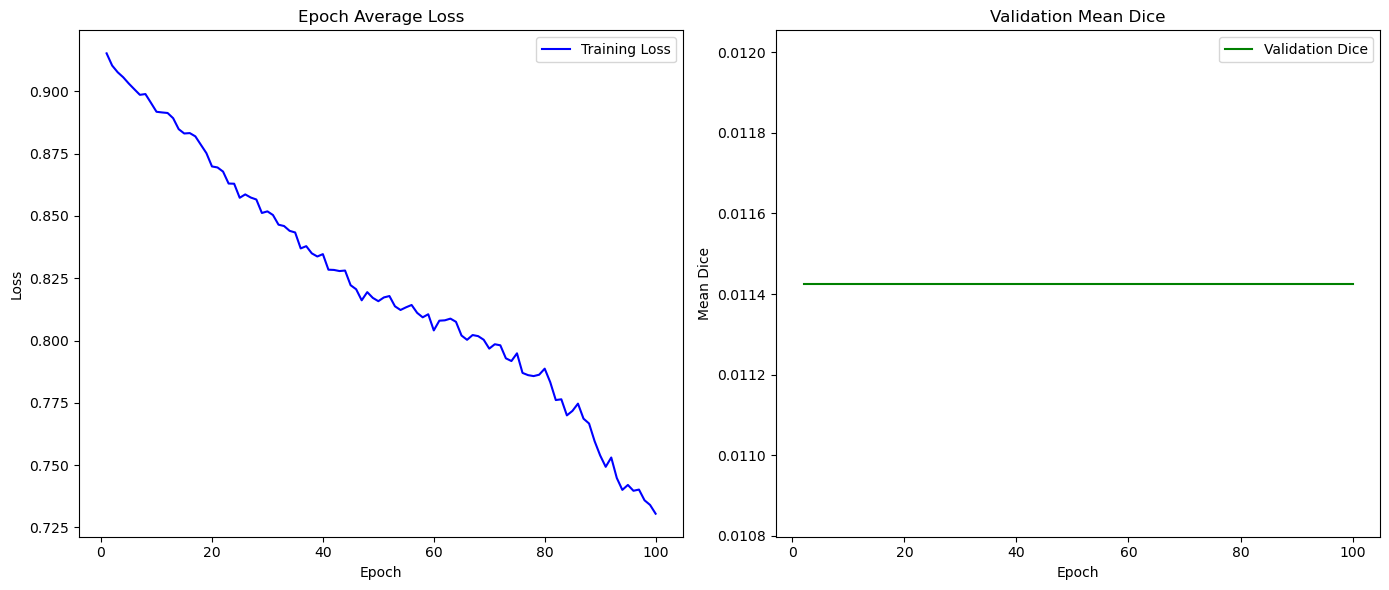

In [56]:
# Define plot parameters
plt.figure(figsize=(14, 6))

# Plot Epoch Average Loss
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
x_loss = [i + 1 for i in range(len(epoch_loss_values))]
y_loss = epoch_loss_values
plt.plot(x_loss, y_loss, color='blue', label='Training Loss')
plt.legend()

# Plot Validation Mean Dice
plt.subplot(1, 2, 2)
plt.title("Validation Mean Dice")
plt.xlabel("Epoch")
plt.ylabel("Mean Dice")
x_dice = [val_interval * (i + 1) for i in range(len(metric_values))]
y_dice = metric_values
plt.plot(x_dice, y_dice, color='green', label='Validation Dice')
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
# Load the best saved model parameters
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

# Set the model to evaluation mode
model.eval()

# Perform inference on validation data using the best model
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device),
                                               roi_size, sw_batch_size, model)

        # Plot the slices
        plt.figure("check", (18, 6))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 50], cmap="gray")

        # Plot ground truth label
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 50])

        # Plot model output
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 50])
        plt.show()

        # Break loop after 3 iterations for visualization
        if i == 2:
            break

RuntimeError: Error(s) in loading state_dict for UNet:
	size mismatch for model.2.0.conv.weight: copying a param with shape torch.Size([32, 5, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 4, 3, 3, 3]).
	size mismatch for model.2.0.conv.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for model.2.0.adn.N.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for model.2.0.adn.N.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for model.2.0.adn.N.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for model.2.0.adn.N.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for model.2.1.conv.unit0.conv.weight: copying a param with shape torch.Size([5, 5, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 4, 3, 3, 3]).
	size mismatch for model.2.1.conv.unit0.conv.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([4]).